# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)


def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))

    
    #1/(10**8.5)*(1/(E-1.5)**4 + 1/(E-3)**4)
    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4) +1/(10**EregCoeffExp)*(1/(E-E1)**EregN + 1/(E-E2)**EregN)


trunc = -1
iterList = []
EregList = []
EregDerList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    Ereg = 1/(10**8.5)*(1/(E-1.5)**4 + 1/(E-3)**4)
    #EregDer = -4/(10**8.5)*(1/(E-1.5)**5 + 1/(E-3)**5)
    EregDer = -EregN/(10**EregCoeffExp)*(1/(E-E1)**(EregN+1) + 1/(E-E2)**(EregN+1))
    
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4) + Ereg
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EregList.append (Ereg)
    EregDerList.append (EregDer)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob) + \
           " Ereg = " + str(Ereg))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("EregDer = " + str(EregDer))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 4 # Length of the well
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 3.25
params = {'nn': nnparams, 'E': initE}
E1 = 2.5
E2 = 4.0
EregN = 10
#EregCoeffExp = (2 - int(np.ceil(np.log10(E2-E1)))) * (EregN + 3)
EregCoeffExp = (2 - np.log10(E2-E1)) * (EregN + 3)

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "L" + floatStr(L) + "E" + floatStr(E1) + "E" + floatStr(initE) + "E" + floatStr(E2)

In [6]:
print (EregCoeffExp)

23.710813632276142


# Optimization

In [7]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 4.89945486018896 prob = 0.9978002508491696 Ereg = 1.3509253992767091e-06
loss = 56.774699487198966 E = 3.219973924340957
EregDer = -4.2305706056117454e-22
---------------------------------
Iteration 200
diffeq = 2.460469653484478 prob = 0.982016813324784 Ereg = 2.877323170969089e-06
loss = 54.35198866408758 E = 3.1820823063528563
EregDer = -1.1315523430570886e-21
diffeqDiff = -2.4389852067044817
---------------------------------
Iteration 300
diffeq = 1.8054148022013021 prob = 0.9855225148534712 Ereg = 1.1392825079433598e-05
loss = 53.69109293858833 E = 3.129076274382311
EregDer = -3.0984955084191578e-21
diffeqDiff = -0.6550548512831758
---------------------------------
Iteration 400
diffeq = 1.4108691027071398 prob = 0.9926372659343976 Ereg = 0.0002533566119867492
loss = 53.288861792563154 E = 3.059438407958691
EregDer = -1.1547219011640805e-20
diffeqDiff = -0.3945456994941623
---------------------------------
Iteration 500
diffeq = 1.1518171304838583 prob = 0.9

Iteration 3400
diffeq = 0.24364348284523848 prob = 0.9975314179901377 Ereg = 5.786455542888329e-08
loss = 52.11894999312575 E = 2.5099328218906303
EregDer = -0.2095980507130694
diffeqDiff = -0.0023830504795709084
brkCount2 = 22
---------------------------------
Iteration 3500
diffeq = 0.24116151899117194 prob = 0.9975450565706194 Ereg = 5.787704202833729e-08
loss = 52.116464648356164 E = 2.5099614927309934
EregDer = -0.20305688588491028
diffeqDiff = -0.0024819638540665434
brkCount2 = 23
---------------------------------
Iteration 3600
diffeq = 0.23857385592571262 prob = 0.997559175338191 Ereg = 5.789035429874137e-08
loss = 52.11387350514337 E = 2.509992049804575
EregDer = -0.1963296429967635
diffeqDiff = -0.0025876630654593225
brkCount2 = 24
---------------------------------
Iteration 3700
diffeq = 0.23587276757888895 prob = 0.9975741438697151 Ereg = 5.790458367190007e-08
loss = 52.11116874919023 E = 2.5100247010384877
EregDer = -0.18940901280030337
diffeqDiff = -0.0027010883468236713


Iteration 6600
diffeq = 0.10360844867655337 prob = 0.9981163195690954 Ereg = 1.449681709060215e-07
loss = 51.978786927010056 E = 2.6143184295321626
EregDer = -4.465885887377419e-13
diffeqDiff = -0.0062349778843449055
brkCount2 = 53
---------------------------------
Iteration 6700
diffeq = 0.10225418011147017 prob = 0.9991541913348967 Ereg = 1.9470245937839084e-07
loss = 51.97729029344227 E = 2.6421522019735866
EregDer = -4.063468170227723e-14
diffeqDiff = -0.0013542685650832081
brkCount2 = 54
---------------------------------
Iteration 6800
diffeq = 0.09034549623293886 prob = 0.9982321219648125 Ereg = 2.6128597114082243e-07
loss = 51.96550282031586 E = 2.667776860304535
EregDer = -6.5634725781803295e-15
diffeqDiff = -0.011908683878531306
---------------------------------
Iteration 6900
diffeq = 0.0835782494499777 prob = 0.9982980849071834 Ereg = 3.4615654130587405e-07
loss = 51.958724146996204 E = 2.6904884996690375
EregDer = -1.6241644266776103e-15
diffeqDiff = -0.006767246782961159
b

Iteration 9700
diffeq = 0.0016928750156602562 prob = 0.9999706664130557 Ereg = 1.2547375637852428e-06
loss = 51.876694172920836 E = 2.775888015352313
EregDer = -2.7613734785178763e-17
diffeqDiff = -5.3572169280672374e-05
brkCount4 = 9
---------------------------------
Iteration 9800
diffeq = 0.0016444136338220844 prob = 0.9999706223563419 Ereg = 1.25468872862452e-06
loss = 51.876645711619936 E = 2.775885832214053
EregDer = -2.7616138521915243e-17
diffeqDiff = -4.8461381838171835e-05
brkCount4 = 10
---------------------------------
Iteration 9900
diffeq = 0.0015970347171201838 prob = 0.9999709633054916 Ereg = 1.2546433490118685e-06
loss = 51.876598331658684 E = 2.7758838034580737
EregDer = -2.7618372481205062e-17
diffeqDiff = -4.737891670190063e-05
brkCount4 = 11
---------------------------------
Iteration 10000
diffeq = 0.010346941007509767 prob = 1.0001285747498627 Ereg = 1.259918123007681e-06
loss = 51.885349030149705 E = 2.776119006074741
EregDer = -2.7360688305553574e-17
diffeqDiff

# Plots

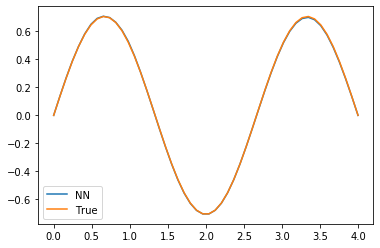

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot (x , np.sqrt(2/L) * np.sin(3*np.pi*x/L), label='True')
plt.legend()
plt.savefig (name + "_plot.png")

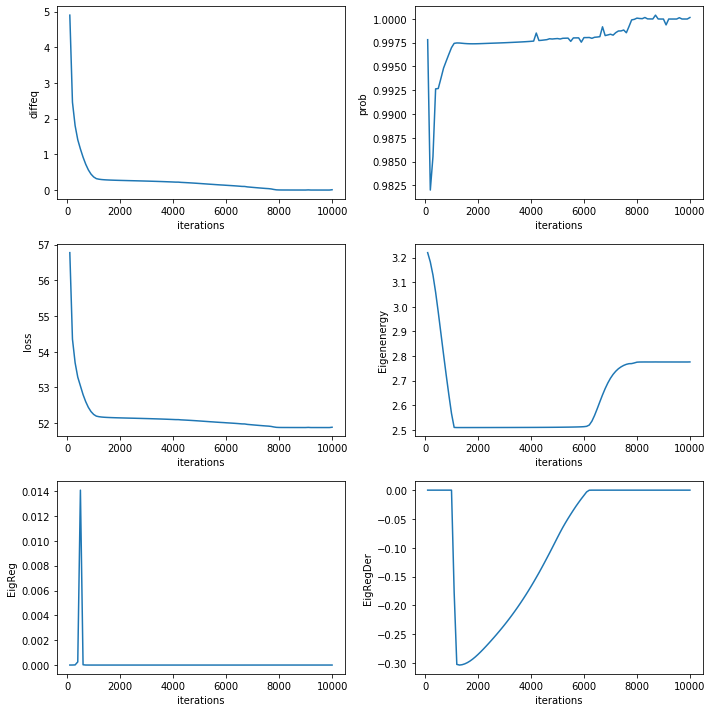

In [14]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (3 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (3, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (3, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (3, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.subplot (3, 2, 5)
plt.plot (iterList, EregList)
plt.ylabel ('EigReg')
plt.xlabel ('iterations')
plt.tight_layout()

plt.subplot (3, 2, 6)
plt.plot (iterList, EregDerList)
plt.ylabel ('EigRegDer')
plt.xlabel ('iterations')
plt.tight_layout()


plt.savefig (name + "_diagAll.png")

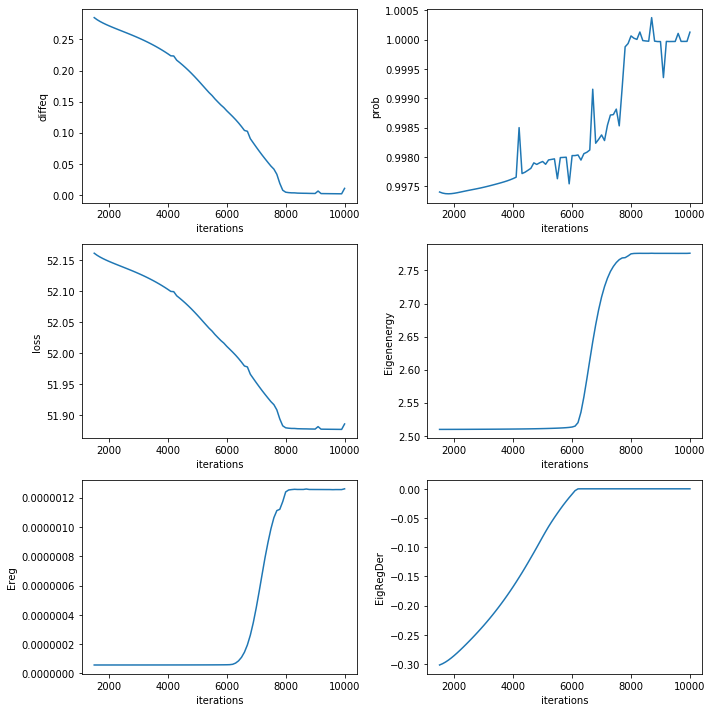

In [15]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (3 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (3, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (3, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (3, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()
    
    plt.subplot (3, 2, 5)
    plt.plot (iterList[trunc:], EregList[trunc:])
    plt.ylabel ('Ereg')
    plt.xlabel ('iterations')
    plt.tight_layout()
    

    plt.subplot (3, 2, 6)
    plt.plot (iterList[trunc:], EregDerList[trunc:])
    plt.ylabel ('EigRegDer')
    plt.xlabel ('iterations')
    plt.tight_layout()


    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

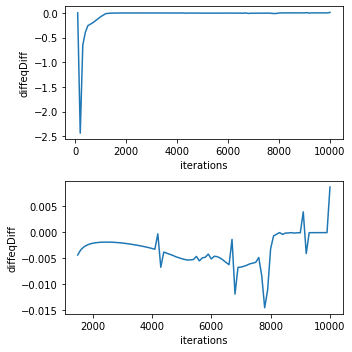

In [16]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [12]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()